In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from importlib import reload
from time import time
import pickle
from copy import deepcopy

import numpy as np
import scipy as sc
import pandas as pd
import torch
print(torch.cuda.is_available())
from statsmodels.stats.weightstats import _zstat_generic

import models
import dre
import rna
from calibrate import rectified_p_value
import vae
import designers
import editdistance

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.size"] = 12

import seaborn as sns
sns.set_style('whitegrid')

PATH = '/homefs/home/wongfanc/density-ratio-estimation'

True


2024-04-12 16:59:50.023193: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 16:59:50.023267: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 16:59:50.024561: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-12 16:59:50.033256: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 16:59:51.943317: W tensorflow/comp

In [2]:
# load calibration data
noise_sd = 0.02
p_mut = 4 / 50
fname = os.path.join(PATH, 'rna-results', 'calibration-pm{:.2f}-nsd{:.2f}-040524.npz'.format(p_mut, noise_sd))
d = np.load(fname)
calseqs_n = list(d['calseqs_n'])
ycal_n = d['ycal_n']

In [3]:
# load training data (can train MDRE using both train and calibration)
model_and_data_path = '/homefs/home/wongfanc/density-ratio-estimation/rna-models'
model_and_data_fname_no_ftype = 'nsd0.02-040324'
n_hidden = 100
n_filters = 32

# load training data
data_fname = os.path.join(model_and_data_path, 'traindata-' + model_and_data_fname_no_ftype + '.npz')
d = np.load(data_fname)
trainseq_n = list(d['trainseq_n'])
ytrain_n = d['ytrain_n']
print(f'Loaded {ytrain_n.size} training points from {data_fname}.\n')

Loaded 5000 training points from /homefs/home/wongfanc/density-ratio-estimation/rna-models/traindata-nsd0.02-040324.npz.



In [4]:
# load models to get predictions for calibration data
model_and_data_path = '/homefs/home/wongfanc/density-ratio-estimation/rna-models'
model_and_data_fname_no_ftype = 'nsd0.02-040324'
n_hidden = 100
n_filters = 32

# train ridge regression, load trained FF and CNN models
ridge = ridge = models.RidgeRegressor(seq_len=50, alphabet=rna.RNA_NUCLEOTIDES)
ridge.fit(trainseq_n, ytrain_n)

ff_fname = os.path.join(model_and_data_path, 'ff-' + model_and_data_fname_no_ftype + '.pt')
ff = models.FeedForward(50, rna.RNA_NUCLEOTIDES, n_hidden)
ff.load(ff_fname)

cnn_fname = os.path.join(model_and_data_path, 'cnn-' + model_and_data_fname_no_ftype + '.pt')
cnn = models.CNN(50, rna.RNA_NUCLEOTIDES, n_filters, n_hidden)
cnn.load(cnn_fname)

name2model = {
    'ridge': ridge,
    'ff': ff,
    'cnn': cnn
}

# DbAS with intermediate steps

In [5]:
reload(vae)
reload(designers)

latent_dim = 10
n_hidden = 20
weight_type = 'dbas'
device = 'cuda'
model_name = 'ridge'

model = name2model[model_name]
cbas = designers.CbAS(
    model,
    trainseq_n,
    latent_dim=latent_dim,
    n_hidden=n_hidden,
    weight_type=weight_type,
    device=device
)

Fitting training distribution:
One-hot encoded sequences to shape = (5000, 50, 4) (0 sec)
4500 training data points, 500 validation data points.
Epoch 0. Train loss: 21.1277, KL: 0.8262, CE: 20.3015. Val loss: 68.0505, KL: 0.0809, CE: 67.9697. (1 s)
Epoch 1. Train loss: 14.9272, KL: 0.0108, CE: 14.9164. Val loss: 14.7339, KL: 0.0125, CE: 14.7214. (1 s)
Epoch 2. Train loss: 14.7733, KL: 0.0103, CE: 14.7630. Val loss: 14.5476, KL: 0.0084, CE: 14.5392. (1 s)
Epoch 3. Train loss: 14.7090, KL: 0.0255, CE: 14.6835. Val loss: 14.4525, KL: 0.0189, CE: 14.4336. (1 s)
Epoch 4. Train loss: 14.6895, KL: 0.0282, CE: 14.6613. Val loss: 14.4162, KL: 0.0291, CE: 14.3871. (1 s)


In [7]:
# intermediate sequences
n_design = 50000
intermediate_iter = list(range(20))
quantile = 0.6

predtrain_n = model.predict(trainseq_n)
disttrain_n = np.array([editdistance.eval(rna.RNABinding.SEEDS[3], s) for s in trainseq_n])
q2preddist = {}
designname2data = {}

iter2designseq = cbas.design_sequences_from_intermediate_distributions(
    n_design,
    intermediate_iter,
    quantile=quantile
)

Fitting design distribution with quantile hyperparameter = 0.6:
Iter 0. Mean, SD, max prediction: 0.286, 0.024, 0.381. 1000 valid samples for threshold 0.290. (2 s)
Iter 1. Mean, SD, max prediction: 0.296, 0.025, 0.402. 1000 valid samples for threshold 0.301. (5 s)
Iter 2. Mean, SD, max prediction: 0.310, 0.026, 0.410. 1000 valid samples for threshold 0.314. (8 s)
Iter 3. Mean, SD, max prediction: 0.329, 0.030, 0.458. 1000 valid samples for threshold 0.336. (11 s)
Iter 4. Mean, SD, max prediction: 0.353, 0.035, 0.487. 1000 valid samples for threshold 0.359. (13 s)
Iter 5. Mean, SD, max prediction: 0.372, 0.039, 0.509. 1000 valid samples for threshold 0.380. (16 s)
Iter 6. Mean, SD, max prediction: 0.399, 0.040, 0.525. 998 valid samples for threshold 0.407. (19 s)
Iter 7. Mean, SD, max prediction: 0.431, 0.043, 0.580. 995 valid samples for threshold 0.440. (22 s)
Iter 8. Mean, SD, max prediction: 0.462, 0.044, 0.597. 988 valid samples for threshold 0.472. (24 s)
Iter 9. Mean, SD, max pr

In [8]:
# construct designname2data after generating designs per intermediate iter
# (no labels yet, need viennanenv, see cell after next)
designname2data = {}

t0 = time()
for t in intermediate_iter:
    designseq_n = iter2designseq[t]
    preddesign_n = model.predict(designseq_n)
    designname2data['{}{:.2f}t{}-ridge'.format(weight_type, quantile, t)] = (designseq_n, None, preddesign_n)
print(int(time() - t0))
    
designname2data['train'] = (calseqs_n + trainseq_n, np.hstack([ycal_n, ytrain_n]), None)
print(designname2data.keys())

14
dict_keys(['dbas0.60t0-ridge', 'dbas0.60t1-ridge', 'dbas0.60t2-ridge', 'dbas0.60t3-ridge', 'dbas0.60t4-ridge', 'dbas0.60t5-ridge', 'dbas0.60t6-ridge', 'dbas0.60t7-ridge', 'dbas0.60t8-ridge', 'dbas0.60t9-ridge', 'dbas0.60t10-ridge', 'dbas0.60t11-ridge', 'dbas0.60t12-ridge', 'dbas0.60t13-ridge', 'dbas0.60t14-ridge', 'dbas0.60t15-ridge', 'dbas0.60t16-ridge', 'dbas0.60t17-ridge', 'dbas0.60t18-ridge', 'dbas0.60t19-ridge', 'train'])


In [9]:
# save
design_pkl_fname = os.path.join(PATH, 'rna-results', '{}-q{:.2f}-designs-041124.pkl'.format(weight_type, quantile))
print(design_pkl_fname)
with open(design_pkl_fname, 'wb') as f:
    pickle.dump(designname2data, f)

/homefs/home/wongfanc/density-ratio-estimation/rna-results/dbas-q0.60-designs-041024.pkl


In [2]:
# change to viennaenv before running this cell
# load and get labels for all designs, re-save
weight_type = 'dbas'
noise_sd = 0.02
quantile = 0.6
landscape = rna.RNABinding(noise_sd=noise_sd)

# note: quantile 0.4 results are under dbas-designs-040924.pkl
design_pkl_fname = os.path.join(PATH, 'rna-results', '{}-q{:.2f}-designs-041124.pkl'.format(weight_type, quantile))
print('Loading and saving designs from/to: {}'.format(design_pkl_fname))
with open(design_pkl_fname, 'rb') as f:
    temp = pickle.load(f)
    
designname2data = {}
t0 = time()
for name, data in temp.items():
    if name != 'train':
        designseq_n, _, preddesign_n = data
        ydesign_n = landscape.get_fitness(designseq_n)
        designname2data[name] = (designseq_n, ydesign_n, preddesign_n)
    else:
        designname2data[name] = data
    
    with open(design_pkl_fname, 'wb') as f:
        pickle.dump(designname2data, f)
        print('{} ({} s)'.format(name, int(time() - t0)))

Loading and saving designs from/to: /homefs/home/wongfanc/density-ratio-estimation/rna-results/dbas-q0.60-designs-041124.pkl
dbas0.60t0-ridge (322 s)
dbas0.60t1-ridge (647 s)
dbas0.60t2-ridge (974 s)
dbas0.60t3-ridge (1303 s)
dbas0.60t4-ridge (1634 s)
dbas0.60t5-ridge (1967 s)
dbas0.60t6-ridge (2303 s)
dbas0.60t7-ridge (2641 s)
dbas0.60t8-ridge (2982 s)
dbas0.60t9-ridge (3325 s)
dbas0.60t10-ridge (3670 s)
dbas0.60t11-ridge (4016 s)
dbas0.60t12-ridge (4363 s)
dbas0.60t13-ridge (4711 s)
dbas0.60t14-ridge (5058 s)
dbas0.60t15-ridge (5405 s)
dbas0.60t16-ridge (5751 s)
dbas0.60t17-ridge (6104 s)
dbas0.60t18-ridge (6454 s)
dbas0.60t19-ridge (6804 s)
train (6805 s)


In [18]:
# load designs with labels (after running previous cell, change back to torchenv),
# for intermediate iters
weight_type = 'dbas'
quantile = 0.6
intermediate_iter = list(range(1, 20, 2)) + [19]

intermediate_iter = list(set(intermediate_iter))
intermediate_iter.sort()
print(intermediate_iter)

design_pkl_fname = os.path.join(PATH, 'rna-results', '{}-q{:.2f}-designs-041124.pkl'.format(weight_type, quantile))
with open(design_pkl_fname, 'rb') as f:
    temp = pickle.load(f)
    
designname2data = {}
for t in intermediate_iter:
    name = '{}{:.2f}t{}-ridge'.format(weight_type, quantile, t)
    designname2data[name] = temp[name]
designname2data['train'] = temp['train']

print(designname2data.keys())

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
dict_keys(['dbas0.60t1-ridge', 'dbas0.60t3-ridge', 'dbas0.60t5-ridge', 'dbas0.60t7-ridge', 'dbas0.60t9-ridge', 'dbas0.60t11-ridge', 'dbas0.60t13-ridge', 'dbas0.60t15-ridge', 'dbas0.60t17-ridge', 'dbas0.60t19-ridge', 'train'])


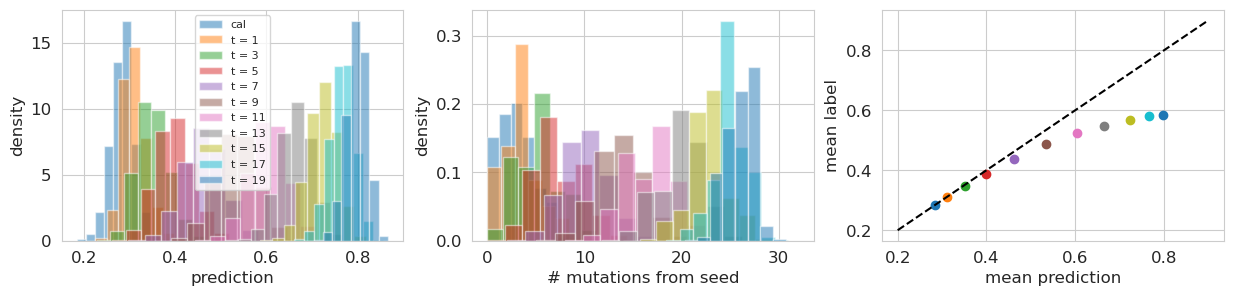

In [19]:
plt.figure(figsize=(15, 3))

predcal_n = name2model['ridge'].predict(calseqs_n)
distcal_n = np.array([editdistance.eval(rna.RNABinding.SEEDS[3], s) for s in calseqs_n])

plt.subplot(131)
plt.hist(predcal_n, alpha=0.5, label='cal', density=True)
plt.xlabel('prediction');
plt.ylabel('density');

plt.subplot(132)
plt.hist(distcal_n, alpha=0.5, label='cal', density=True)
plt.xlabel('# mutations from seed');
plt.ylabel('density');

plt.subplot(133)
plt.scatter(np.mean(predcal_n), np.mean(ycal_n))
plt.plot([0.2, 0.9], [0.2, 0.9], '--k');
plt.xlabel('mean prediction'); plt.ylabel('mean label');

for t in intermediate_iter:
    designseq_n, ydesign_n, preddesign_n = designname2data['{}{:.2f}t{}-ridge'.format(weight_type, quantile, t)]
    distdesign_n = np.array([editdistance.eval(rna.RNABinding.SEEDS[3], s) for s in designseq_n])

    plt.subplot(131)
    plt.hist(preddesign_n, alpha=0.5, label='t = {}'.format(t), density=True)

    plt.subplot(132)
    plt.hist(distdesign_n, alpha=0.5, density=True)
    
    plt.subplot(133)
    plt.scatter(np.mean(preddesign_n), np.mean(ydesign_n))
    
plt.subplot(131)
plt.legend(fontsize=8);

One-hot-encoding all 11 categories of sequences...
  Done. (9 s)


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:23<00:00, 20.85it/s]


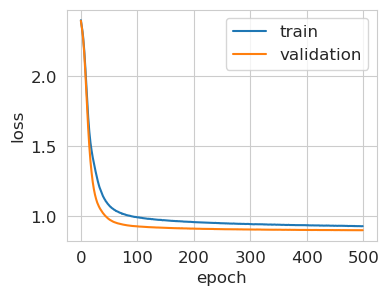

In [20]:
# fit MDRE
reload(dre)
n_hidden = 256
n_epoch = 500
lr = 1e-3

device = torch.device('cuda')

mdre = dre.MultinomialLogisticRegresssionDensityRatioEstimator(
    50,
    len(designname2data.keys()),
    n_hidden,
    device=device
)
loss_df = mdre.fit(
    designname2data,
    n_epoch,
    lr=lr
)

plt.figure(figsize=(4, 3))
plt.plot(loss_df['train_loss'], label='train')
plt.plot(loss_df['val_loss'], label='validation')
plt.legend() 
plt.xlabel('epoch');
plt.ylabel('loss');
# plt.ylim([0, 1]);

In [21]:
# point estimates
alpha = 0.1
target_values = np.arange(0.3, 0.81, 0.01)
final_name = '{}{:.2f}t19-ridge'.format(weight_type, quantile)

# get DRs for each design distribution
designname2dr = mdre.get_dr(calseqs_n, self_normalize=True)
impaccept_t = []
ppaccept_t = []
pointest_mx3 = np.zeros([len(designname2data), 3])
ciwidth_mx2 = np.zeros([len(designname2data), 2])
for i, data in enumerate(designname2data.items()):
    
    design_name, (designseq_n, ydesign_n, preddesign_n) = data
    for model_name in name2model.keys():
        if model_name in design_name:
            model = name2model[model_name]
            print('using {} for {}'.format(model_name, design_name))
    
    if design_name != 'train':
        print(design_name)
        
        imputed_mean = np.mean(preddesign_n)
        imputed_se = np.std(preddesign_n) / np.sqrt(preddesign_n.size)
        
        caldr_n = designname2dr[design_name]
        predcal_n = model.predict(calseqs_n)
        rect_n = caldr_n * (ycal_n - predcal_n)
        rectifier_mean = np.mean(rect_n)
        rectifier_se = np.std(rect_n) / np.sqrt(rect_n.size)
        pointest_mx3[i] = np.mean(ydesign_n), np.mean(preddesign_n) + rectifier_mean, np.mean(preddesign_n)
        
        pp_se = np.maximum(np.sqrt(imputed_se ** 2 + rectifier_se ** 2), 1e-16)
        ciwidth_mx2[i] = pp_se, imputed_se

        print('{:.3f} {:.3f} {:.3f}\n'.format(
            np.mean(ydesign_n), np.mean(preddesign_n), np.mean(preddesign_n) + rectifier_mean
        ))
    else:
        train_idx = i
pointest_mx3 = np.delete(pointest_mx3, train_idx, axis=0)
ciwidth_mx2 = np.delete(ciwidth_mx2, train_idx, axis=0)

# for final category only
designseq_n, ydesign_n, preddesign_n = designname2data[final_name]
imputed_mean = np.mean(preddesign_n)
imputed_se = np.std(preddesign_n) / np.sqrt(preddesign_n.size)
caldr_n = designname2dr[final_name]
predcal_n = model.predict(calseqs_n)
rect_n = caldr_n * (ycal_n - predcal_n)
rectifier_mean = np.mean(rect_n)
rectifier_se = np.std(rect_n) / np.sqrt(rect_n.size)
for target_val in target_values:
    
    # run imputation hypothesis test
    imp_pval = _zstat_generic(
        imputed_mean,
        0,
        imputed_se,
        alternative='larger',
        diff=target_val
    )[1]

    # run prediction-powered hypothesis test
    pp_pval = rectified_p_value(
        rectifier_mean,
        rectifier_se,
        imputed_mean,
        imputed_se,
        null=target_val,
        alternative='larger'
    )

    impaccept_t.append((imp_pval < alpha).astype(float))
    ppaccept_t.append((pp_pval < alpha).astype(float))

using ridge for dbas0.60t1-ridge
dbas0.60t1-ridge
0.310 0.310 0.310

using ridge for dbas0.60t3-ridge
dbas0.60t3-ridge
0.347 0.351 0.347

using ridge for dbas0.60t5-ridge
dbas0.60t5-ridge
0.387 0.399 0.389

using ridge for dbas0.60t7-ridge
dbas0.60t7-ridge
0.438 0.463 0.452

using ridge for dbas0.60t9-ridge
dbas0.60t9-ridge
0.487 0.534 0.513

using ridge for dbas0.60t11-ridge
dbas0.60t11-ridge
0.524 0.604 0.577

using ridge for dbas0.60t13-ridge
dbas0.60t13-ridge
0.549 0.665 0.632

using ridge for dbas0.60t15-ridge
dbas0.60t15-ridge
0.569 0.722 0.696

using ridge for dbas0.60t17-ridge
dbas0.60t17-ridge
0.581 0.765 0.744

using ridge for dbas0.60t19-ridge
dbas0.60t19-ridge
0.583 0.798 0.781



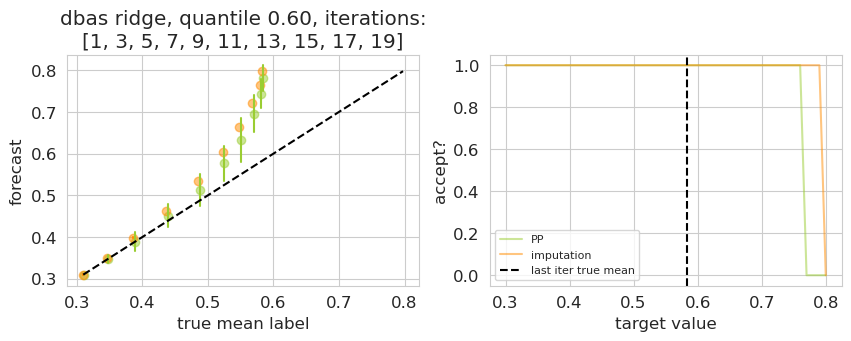

In [22]:
# run preliminary selection experiments and plot
title = '{} ridge, quantile {:.2f}, iterations:\n{}'.format(weight_type, quantile, intermediate_iter)
truemean = np.mean(designname2data[final_name][1])
ppoff = 0.001
impoff = -0.001

xy_lim = [np.min(target_values), np.max(target_values)]

plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.scatter(pointest_mx3[:, 0] + ppoff, pointest_mx3[:, 1], label='PP', c='yellowgreen', alpha=0.5)
plt.scatter(pointest_mx3[:, 0] + impoff, pointest_mx3[:, 2], label='imputation', c='darkorange', alpha=0.5)
for pe_x3, ciw_x2 in zip(pointest_mx3, ciwidth_mx2):
    plt.plot([pe_x3[0] + ppoff, pe_x3[0] + ppoff], [pe_x3[1] - 2 * ciw_x2[0], pe_x3[1] + 2 * ciw_x2[0]], c='yellowgreen')
    plt.plot([pe_x3[0] + impoff, pe_x3[0] + impoff], [pe_x3[2] - 2 * ciw_x2[1], pe_x3[2] + 2 * ciw_x2[1]], c='darkorange')
plt.plot([np.min(pointest_mx3), np.max(pointest_mx3)], [np.min(pointest_mx3), np.max(pointest_mx3)], '--k');
plt.xlabel('true mean label');
plt.ylabel('forecast');
plt.title(title);

plt.subplot(122)
plt.plot(target_values, ppaccept_t, label='PP', c='yellowgreen', alpha=0.5)
plt.plot(target_values, impaccept_t, label='imputation', c='darkorange', alpha=0.5)
plt.axvline(truemean, linestyle='--', color='k', label='last iter true mean')
plt.xlabel('target value');
plt.ylabel('accept?');
plt.legend(fontsize=8);

# checking which DbAS/CbAS quantiles move

In [5]:
reload(vae)
reload(designers)

latent_dim = 10
n_hidden = 20
weight_type = 'dbas'
device = 'cuda'
model_name = 'ff'

model = name2model[model_name]
cbas = designers.CbAS(
    model,
    trainseq_n,
    latent_dim=latent_dim,
    n_hidden=n_hidden,
    weight_type=weight_type,
    device=device
)

Fitting training distribution:
One-hot encoded sequences to shape = (5000, 50, 4) (0 sec)
4500 training data points, 500 validation data points.
Epoch 0. Train loss: 22.4215, KL: 0.8997, CE: 21.5218. Val loss: 70.6274, KL: 0.1451, CE: 70.4823. (1 s)
Epoch 1. Train loss: 14.8940, KL: 0.0256, CE: 14.8684. Val loss: 15.1603, KL: 0.0387, CE: 15.1216. (1 s)
Epoch 2. Train loss: 14.7262, KL: 0.0379, CE: 14.6883. Val loss: 14.9140, KL: 0.0211, CE: 14.8929. (1 s)
Epoch 3. Train loss: 14.6909, KL: 0.0495, CE: 14.6414. Val loss: 14.8269, KL: 0.0481, CE: 14.7789. (1 s)
Epoch 4. Train loss: 14.6629, KL: 0.0455, CE: 14.6174. Val loss: 14.8135, KL: 0.0434, CE: 14.7701. (1 s)


In [6]:
# design with different quantiles
n_design = 50000
quantiles = np.arange(0.1, 0.91, 0.1)

predtrain_n = model.predict(trainseq_n)
disttrain_n = np.array([editdistance.eval(rna.RNABinding.SEEDS[3], s) for s in trainseq_n])
q2seqpreddist = {}

for q in quantiles:
    designseq_n = cbas.design_sequences(
        n_design,
        quantile=q
    )
    preddesign_n = model.predict(designseq_n)
    distdesign_n = np.array([editdistance.eval(rna.RNABinding.SEEDS[3], s) for s in designseq_n])
    print('quantile {:.2f}, mean prediction {:.2f}, mean distance {:.2f}\n'.format(
        q, np.mean(preddesign_n), np.mean(distdesign_n)
    ))
    q2seqpreddist[q] = (designseq_n, preddesign_n, distdesign_n)

Fitting design distribution with quantile hyperparameter = 0.1:
Iter 0. Mean, SD, max prediction: 0.283, 0.024, 0.380. 1000 valid samples for threshold 0.252. (2 s)
Iter 1. Mean, SD, max prediction: 0.283, 0.023, 0.384. 1000 valid samples for threshold 0.254. (5 s)
Iter 2. Mean, SD, max prediction: 0.284, 0.023, 0.357. 1000 valid samples for threshold 0.254. (8 s)
Iter 3. Mean, SD, max prediction: 0.285, 0.022, 0.354. 1000 valid samples for threshold 0.255. (11 s)
Iter 4. Mean, SD, max prediction: 0.286, 0.023, 0.381. 1000 valid samples for threshold 0.257. (14 s)
Iter 5. Mean, SD, max prediction: 0.290, 0.024, 0.378. 1000 valid samples for threshold 0.260. (17 s)
Iter 6. Mean, SD, max prediction: 0.288, 0.023, 0.364. 1000 valid samples for threshold 0.260. (19 s)
Iter 7. Mean, SD, max prediction: 0.289, 0.024, 0.386. 1000 valid samples for threshold 0.260. (22 s)
Iter 8. Mean, SD, max prediction: 0.289, 0.022, 0.361. 1000 valid samples for threshold 0.260. (25 s)
Iter 9. Mean, SD, max

Iter 16. Mean, SD, max prediction: 0.299, 0.020, 0.380. 1000 valid samples for threshold 0.292. (48 s)
Iter 17. Mean, SD, max prediction: 0.297, 0.019, 0.394. 1000 valid samples for threshold 0.292. (51 s)
Iter 18. Mean, SD, max prediction: 0.299, 0.020, 0.364. 1000 valid samples for threshold 0.292. (54 s)
Iter 19. Mean, SD, max prediction: 0.298, 0.020, 0.398. 1000 valid samples for threshold 0.292. (57 s)
quantile 0.40, mean prediction 0.30, mean distance 2.26

Fitting design distribution with quantile hyperparameter = 0.5:
Iter 0. Mean, SD, max prediction: 0.284, 0.024, 0.385. 1000 valid samples for threshold 0.287. (2 s)
Iter 1. Mean, SD, max prediction: 0.287, 0.024, 0.374. 1000 valid samples for threshold 0.287. (5 s)
Iter 2. Mean, SD, max prediction: 0.291, 0.024, 0.375. 1000 valid samples for threshold 0.289. (8 s)
Iter 3. Mean, SD, max prediction: 0.291, 0.023, 0.361. 1000 valid samples for threshold 0.289. (11 s)
Iter 4. Mean, SD, max prediction: 0.294, 0.024, 0.369. 1000 va

Iter 12. Mean, SD, max prediction: 0.316, 0.026, 0.409. 1000 valid samples for threshold 0.337. (37 s)
Iter 13. Mean, SD, max prediction: 0.326, 0.028, 0.433. 1000 valid samples for threshold 0.350. (40 s)
Iter 14. Mean, SD, max prediction: 0.331, 0.030, 0.432. 1000 valid samples for threshold 0.357. (42 s)
Iter 15. Mean, SD, max prediction: 0.338, 0.031, 0.449. 1000 valid samples for threshold 0.364. (45 s)
Iter 16. Mean, SD, max prediction: 0.346, 0.032, 0.451. 1000 valid samples for threshold 0.373. (48 s)
Iter 17. Mean, SD, max prediction: 0.357, 0.035, 0.501. 1000 valid samples for threshold 0.387. (51 s)
Iter 18. Mean, SD, max prediction: 0.367, 0.037, 0.489. 1000 valid samples for threshold 0.397. (54 s)
Iter 19. Mean, SD, max prediction: 0.367, 0.035, 0.484. 1000 valid samples for threshold 0.397. (57 s)
quantile 0.80, mean prediction 0.38, mean distance 6.73

Fitting design distribution with quantile hyperparameter = 0.9:
Iter 0. Mean, SD, max prediction: 0.284, 0.023, 0.355. 

/homefs/home/wongfanc/miniconda3/envs/torchenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homefs/home/wongfanc/miniconda3/envs/torchenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/homefs/home/wongfanc/miniconda3/envs/torchenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homefs/home/wongfanc/miniconda3/envs/torchenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_in

/homefs/home/wongfanc/miniconda3/envs/torchenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homefs/home/wongfanc/miniconda3/envs/torchenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/homefs/home/wongfanc/miniconda3/envs/torchenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homefs/home/wongfanc/miniconda3/envs/torchenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_in

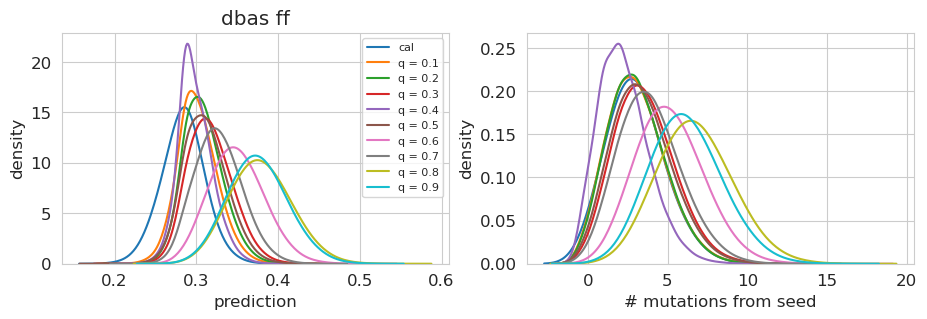

In [7]:
# plot different quantile design distributions
plt.figure(figsize=(11, 3))
bw_adjust = 3

predcal_n = model.predict(calseqs_n)
distcal_n = np.array([editdistance.eval(rna.RNABinding.SEEDS[3], s) for s in calseqs_n])

plt.subplot(121)
sns.kdeplot(predcal_n, label='cal', bw_adjust=bw_adjust)
plt.xlabel('prediction');
plt.ylabel('density');
plt.title('{} {}'.format(weight_type, model_name))

plt.subplot(122)
sns.kdeplot(distcal_n, label='cal', bw_adjust=bw_adjust)
plt.xlabel('# mutations from seed');
plt.ylabel('density');

for q in quantiles:
    _, preddesign_n, distdesign_n = q2seqpreddist[q]
    
    plt.subplot(121)
    sns.kdeplot(preddesign_n, label='q = {:.1f}'.format(q), bw_adjust=bw_adjust)

    plt.subplot(122)
    sns.kdeplot(distdesign_n, bw_adjust=bw_adjust)
    
plt.subplot(121)
plt.legend(fontsize=8);


In [9]:
# next few cells: see if can do MDRE with no intermediate iters.
# construct designname2data after generating designs per quantile
# (no labels yet, need viennanenv, see cell after next)
designname2data = {}

for q in quantiles:
    designseq_n, preddesign_n, _ = q2seqpreddist[q]
    designname2data['{}{:.2f}-{}'.format(weight_type, q, model_name)] = (designseq_n, None, preddesign_n)
    
designname2data['train'] = (calseqs_n + trainseq_n, np.hstack([ycal_n, ytrain_n]), None)
print(designname2data.keys())


dict_keys(['dbas0.10-ff', 'dbas0.20-ff', 'dbas0.30-ff', 'dbas0.40-ff', 'dbas0.50-ff', 'dbas0.60-ff', 'dbas0.70-ff', 'dbas0.80-ff', 'dbas0.90-ff', 'train'])


In [10]:
# save
design_pkl_fname = os.path.join(PATH, 'rna-results', '{}-{}-designs-041124.pkl'.format(weight_type, model_name))
print(design_pkl_fname)
with open(design_pkl_fname, 'wb') as f:
    pickle.dump(designname2data, f)
    

/homefs/home/wongfanc/density-ratio-estimation/rna-results/dbas-ff-designs-041124.pkl


In [2]:
# change to viennaenv before running this cell
# load and get labels for all designs, re-save
weight_type = 'dbas'
model_name = 'ff'
noise_sd = 0.02

landscape = rna.RNABinding(noise_sd=noise_sd)
design_pkl_fname = os.path.join(PATH, 'rna-results', '{}-{}-designs-041124.pkl'.format(weight_type, model_name))
print('Loading and saving designs from/to: {}'.format(design_pkl_fname))
with open(design_pkl_fname, 'rb') as f:
    temp = pickle.load(f)
    
designname2data = {}
t0 = time()
for name, data in temp.items():
    if name != 'train':
        designseq_n, ydesign_n, preddesign_n = data
        if ydesign_n is None:
            ydesign_n = landscape.get_fitness(designseq_n)
            designname2data[name] = (designseq_n, ydesign_n, preddesign_n)
        else:
            designname2data[name] = data
    else:
        designname2data[name] = data
    
    with open(design_pkl_fname, 'wb') as f:
        pickle.dump(designname2data, f)
    
    print('{} ({} s)'.format(name, int(time() - t0)))
    

Loading and saving designs from/to: /homefs/home/wongfanc/density-ratio-estimation/rna-results/dbas-ff-designs-041124.pkl
dbas0.10-ff (325 s)
dbas0.20-ff (651 s)
dbas0.30-ff (976 s)
dbas0.40-ff (1302 s)
dbas0.50-ff (1629 s)
dbas0.60-ff (1957 s)
dbas0.70-ff (2286 s)
dbas0.80-ff (2620 s)
dbas0.90-ff (2955 s)
train (2955 s)


In [10]:
# load designs with labels (after running previous cell, change back to torchenv)
weight_type = 'dbas'
quantile = 0.1
model_name = 'ff'

design_pkl_fname = os.path.join(PATH, 'rna-results', '{}-{}-designs-041124.pkl'.format(weight_type, model_name))
with open(design_pkl_fname, 'rb') as f:
    designname2data = pickle.load(f)
    
# designname2data = {
#     'train': temp['train'],
#     '{}{:.2f}-{}'.format(weight_type, quantile, model_name): temp['{}{:.2f}-{}'.format(weight_type, quantile, model_name)]
# } 

print(designname2data.keys())

dict_keys(['dbas0.10-ff', 'dbas0.20-ff', 'dbas0.30-ff', 'dbas0.40-ff', 'dbas0.50-ff', 'dbas0.60-ff', 'dbas0.70-ff', 'dbas0.80-ff', 'dbas0.90-ff', 'train'])


One-hot-encoding all 10 categories of sequences...
  Done. (6 s)


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:19<00:00, 25.66it/s]


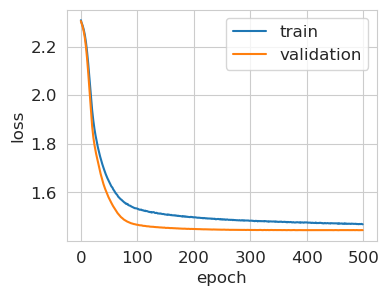

In [11]:
# fit MDRE
reload(dre)
n_hidden = 256
n_epoch = 500
lr = 1e-3

device = torch.device('cuda')

mdre = dre.MultinomialLogisticRegresssionDensityRatioEstimator(
    50,
    len(designname2data.keys()),
    n_hidden,
    device=device
)
loss_df = mdre.fit(
    designname2data,
    n_epoch,
    lr=lr
)

plt.figure(figsize=(4, 3))
plt.plot(loss_df['train_loss'], label='train')
plt.plot(loss_df['val_loss'], label='validation')
plt.legend() 
plt.xlabel('epoch');
plt.ylabel('loss');
# plt.ylim([0, 1]);

In [12]:
# point estimates
alpha = 0.1
target_values = np.arange(0.3, 0.41, 0.01)
model = name2model[model_name]

# get DRs for each design distribution
designname2dr = mdre.get_dr(calseqs_n, self_normalize=True)
imp_target2name = {val: [] for val in target_values}
pp_target2name = {val: [] for val in target_values}
pointest_mx3 = np.zeros([len(designname2data), 3])
ciwidth_mx2 = np.zeros([len(designname2data), 2])

for i, data in enumerate(designname2data.items()):
    
    design_name, (designseq_n, ydesign_n, preddesign_n) = data
    
    if design_name != 'train':
        print(design_name)
        
        imputed_mean = np.mean(preddesign_n)
        imputed_se = np.std(preddesign_n) / np.sqrt(preddesign_n.size)
        
        caldr_n = designname2dr[design_name]
        predcal_n = model.predict(calseqs_n)
        rect_n = caldr_n * (ycal_n - predcal_n)
        rectifier_mean = np.mean(rect_n)
        rectifier_se = np.std(rect_n) / np.sqrt(rect_n.size)
        pp_se = np.maximum(np.sqrt(imputed_se ** 2 + rectifier_se ** 2), 1e-16)
        pointest_mx3[i] = np.mean(ydesign_n), np.mean(preddesign_n) + rectifier_mean, np.mean(preddesign_n)
        ciwidth_mx2[i] = pp_se, imputed_se

        print('{:.3f} {:.3f} {:.3f}'.format(
            np.mean(ydesign_n), np.mean(preddesign_n), np.mean(preddesign_n) + rectifier_mean
        ))
        
        for target_val in target_values:

            # run imputation hypothesis test
            imp_pval = _zstat_generic(
                imputed_mean,
                0,
                imputed_se,
                alternative='larger',
                diff=target_val
            )[1]

            # run prediction-powered hypothesis test
            pp_pval = rectified_p_value(
                rectifier_mean,
                rectifier_se,
                imputed_mean,
                imputed_se,
                null=target_val,
                alternative='larger'
            )

            # Bonferroni correction
            if imp_pval < alpha / (len(designname2data) - 1):
                imp_target2name[target_val].append(design_name)
                
            if pp_pval < alpha / (len(designname2data) - 1):
                pp_target2name[target_val].append(design_name)
    else:
        train_idx = i
pointest_mx3 = np.delete(pointest_mx3, train_idx, axis=0)
ciwidth_mx2 = np.delete(ciwidth_mx2, train_idx, axis=0)

dbas0.10-ff
0.303 0.302 0.303
dbas0.20-ff
0.310 0.308 0.308
dbas0.30-ff
0.319 0.317 0.319
dbas0.40-ff
0.301 0.299 0.300
dbas0.50-ff
0.314 0.311 0.313
dbas0.60-ff
0.349 0.350 0.348
dbas0.70-ff
0.330 0.327 0.325
dbas0.80-ff
0.376 0.379 0.369
dbas0.90-ff
0.374 0.375 0.349


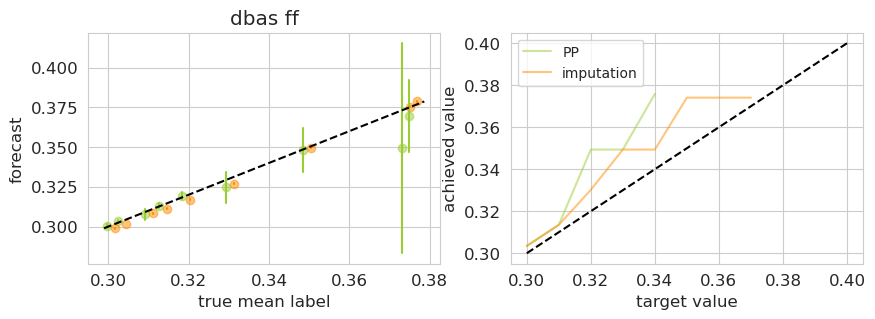

In [13]:
# run preliminary selection experiments and plot
title = '{} {}'.format(weight_type, model_name)
impoff = 0.001
ppoff = -0.001

impach_t = []
ppach_t = []
xy_lim = [np.min(target_values), np.max(target_values)]

for val in target_values:
    names = imp_target2name[val]
    imp_truemeans = [np.mean(designname2data[name][1]) for name in names]
    if len(imp_truemeans):
        impach_t.append(np.min(imp_truemeans))
    else:
        impach_t.append(np.nan)
    
    names = pp_target2name[val]
    pp_truemeans = [np.mean(designname2data[name][1]) for name in names]
    if len(pp_truemeans):
        ppach_t.append(np.min(pp_truemeans))
    else:
        ppach_t.append(np.nan)

plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.scatter(pointest_mx3[:, 0] + ppoff, pointest_mx3[:, 1], label='PP', c='yellowgreen', alpha=0.5)
for pe_x3, ciw_x2 in zip(pointest_mx3, ciwidth_mx2):
    plt.plot([pe_x3[0] + ppoff, pe_x3[0] + ppoff], [pe_x3[1] - 2 * ciw_x2[0], pe_x3[1] + 2 * ciw_x2[0]], c='yellowgreen')
    plt.plot([pe_x3[0] + impoff, pe_x3[0] + impoff], [pe_x3[2] - 2 * ciw_x2[1], pe_x3[2] + 2 * ciw_x2[1]], c='darkorange')

plt.scatter(pointest_mx3[:, 0] + impoff, pointest_mx3[:, 2], label='imputation', c='darkorange', alpha=0.5) 
plt.plot([np.min(pointest_mx3), np.max(pointest_mx3)], [np.min(pointest_mx3), np.max(pointest_mx3)], '--k');
plt.xlabel('true mean label');
plt.ylabel('forecast');
plt.title(title);

plt.subplot(122)
plt.plot(target_values, ppach_t, label='PP', c='yellowgreen', alpha=0.5)
plt.plot(target_values, impach_t, label='imputation', c='darkorange', alpha=0.5)
plt.plot(xy_lim, xy_lim, '--k');
plt.xlabel('target value');
plt.ylabel('achieved value');
plt.legend(fontsize=10);